In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.15.0


# Load Dataset

In [30]:
data = pd.read_csv("../dataset/dataset.csv")
data.head(10)

,Jenis_Kelamin(L/P),Usia(Bulan),Berat(Kg),Tinggi(Cm),Lingkar_Kepala(Cm),BeratBadan/Umur,TinggiBadan/Umur,BeratBadan/TinggiBadan,LingkarKepala/Umur&JenisKelamin
0,L,20,8.0,76.0,47.7,Kurang,Pendek,Gizi Kurang,Normal
1,L,49,12.0,98.0,50.3,Kurang,Normal,Gizi Kurang,Normal
2,P,46,16.7,101.0,48.8,Normal,Normal,Normal,Normal
3,P,42,15.0,97.0,43.6,Normal,Normal,Normal,Mikrosefali
4,L,39,13.5,91.0,50.5,Normal,Normal,Normal,Normal
5,P,39,11.5,91.0,49.9,Normal,Normal,Normal,Normal
6,P,38,13.0,95.0,50.6,Normal,Normal,Normal,Normal
7,L,35,12.5,89.0,52.6,Normal,Normal,Normal,Makrosefali
8,P,33,13.0,88.4,46.5,Normal,Normal,Normal,Normal
9,L,28,12.8,88.0,47.1,Normal,Normal,Normal,Normal


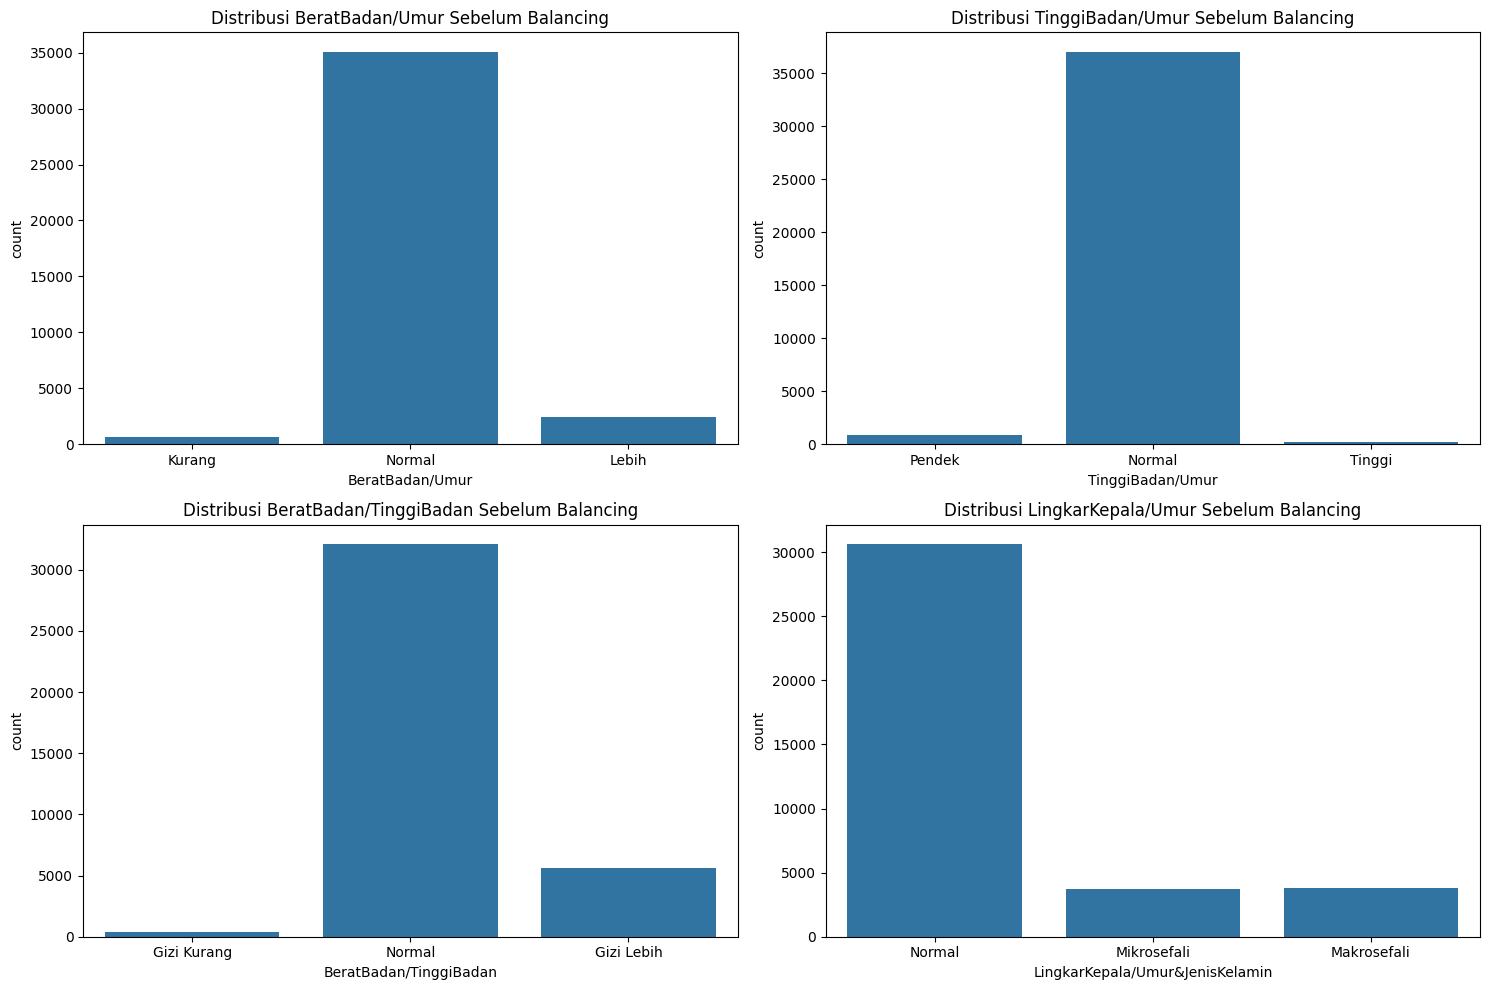

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(ax=axes[0, 0], x='BeratBadan/Umur', data=data)
axes[0, 0].set_title('Distribusi BeratBadan/Umur Sebelum Balancing')

sns.countplot(ax=axes[0, 1], x='TinggiBadan/Umur', data=data)
axes[0, 1].set_title('Distribusi TinggiBadan/Umur Sebelum Balancing')

sns.countplot(ax=axes[1, 0], x='BeratBadan/TinggiBadan', data=data)
axes[1, 0].set_title('Distribusi BeratBadan/TinggiBadan Sebelum Balancing')

sns.countplot(ax=axes[1, 1], x='LingkarKepala/Umur&JenisKelamin', data=data)
axes[1, 1].set_title('Distribusi LingkarKepala/Umur Sebelum Balancing')

plt.tight_layout()
plt.show()

# Normalized

In [32]:
data['Jenis_Kelamin(L/P)'] = data['Jenis_Kelamin(L/P)'].map({'L':1, 'P':0})

In [33]:
print(data['Jenis_Kelamin(L/P)'].unique())

[1 0]


In [34]:
scaler = StandardScaler()
numerik_fitur = ['Jenis_Kelamin(L/P)', 'Usia(Bulan)', 'Berat(Kg)', 'Tinggi(Cm)', 'Lingkar_Kepala(Cm)']
data[numerik_fitur] = scaler.fit_transform(data[numerik_fitur])

# Label encoding untuk kategori
label_encoders = {}
kategori_fitur = ['BeratBadan/Umur', 'TinggiBadan/Umur', 'BeratBadan/TinggiBadan', 'LingkarKepala/Umur&JenisKelamin']
for column in kategori_fitur:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Fitur dan label
X = data[numerik_fitur]
y = data[kategori_fitur]

# Balancing Data

In [35]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = [], []
for column in y.columns:
    X_resampled_col, y_resampled_col = smote.fit_resample(X, y[column])
    X_resampled.append(X_resampled_col)
    y_resampled.append(y_resampled_col)

In [36]:
X_resampled_df = pd.concat(X_resampled, axis=1)
y_resampled_df = pd.concat(y_resampled, axis=1)

In [37]:
resampled_data = pd.concat([X_resampled_df, y_resampled_df], axis=1)

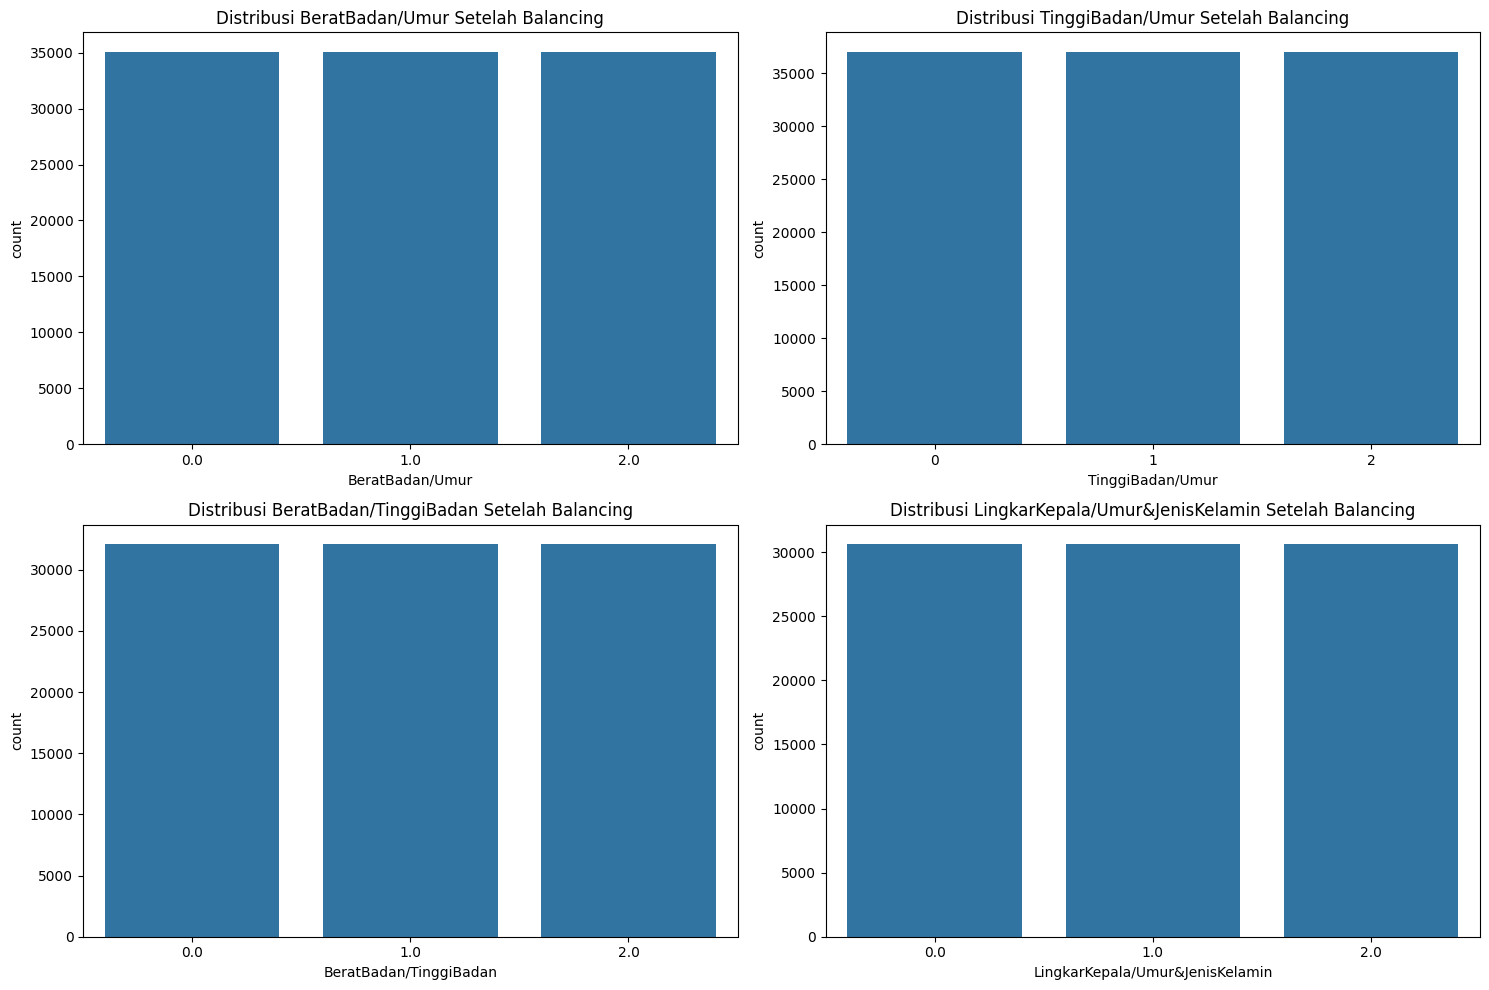

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(ax=axes[0, 0], x='BeratBadan/Umur', data=resampled_data)
axes[0, 0].set_title('Distribusi BeratBadan/Umur Setelah Balancing')

sns.countplot(ax=axes[0, 1], x='TinggiBadan/Umur', data=resampled_data)
axes[0, 1].set_title('Distribusi TinggiBadan/Umur Setelah Balancing')

sns.countplot(ax=axes[1, 0], x='BeratBadan/TinggiBadan', data=resampled_data)
axes[1, 0].set_title('Distribusi BeratBadan/TinggiBadan Setelah Balancing')

sns.countplot(ax=axes[1, 1], x='LingkarKepala/Umur&JenisKelamin', data=resampled_data)
axes[1, 1].set_title('Distribusi LingkarKepala/Umur&JenisKelamin Setelah Balancing')

plt.tight_layout()
plt.show()

# Split Data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Model MLP

In [54]:
# Define model architecture
input_layer = Input(shape=(X_train.shape[1],))

# Shared layers
shared = Dense(32, activation='relu')(input_layer)
shared = Dense(64, activation='relu')(shared)
shared = Dense(64, activation='relu')(shared)
shared = Dense(128, activation='relu')(shared)

# Output layers
output_1 = Dense(len(label_encoders['BeratBadan/Umur'].classes_), activation='softmax', name='output_1')(shared)
output_2 = Dense(len(label_encoders['TinggiBadan/Umur'].classes_), activation='softmax', name='output_2')(shared)
output_3 = Dense(len(label_encoders['BeratBadan/TinggiBadan'].classes_), activation='softmax', name='output_3')(shared)
output_4 = Dense(len(label_encoders['LingkarKepala/Umur&JenisKelamin'].classes_), activation='softmax', name='output_4')(shared)

# Model
model = Model(inputs=input_layer, outputs=[output_1, output_2, output_3, output_4])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
# Train model
history = model.fit(X_train,
                    [y_train['BeratBadan/Umur'], y_train['TinggiBadan/Umur'], y_train['BeratBadan/TinggiBadan'], y_train['LingkarKepala/Umur&JenisKelamin']],
                    epochs=50,
                    batch_size=8,
                    validation_split=0.2)

Epoch 1/50
3050/3050 [==============================] - 23s 7ms/step - loss: 0.6482 - output_1_loss: 0.1509 - output_2_loss: 0.1271 - output_3_loss: 0.2365 - output_4_loss: 0.1337 - output_1_accuracy: 0.9522 - output_2_accuracy: 0.9693 - output_3_accuracy: 0.9111 - output_4_accuracy: 0.9579 - val_loss: 0.3774 - val_output_1_loss: 0.0729 - val_output_2_loss: 0.0914 - val_output_3_loss: 0.1359 - val_output_4_loss: 0.0772 - val_output_1_accuracy: 0.9728 - val_output_2_accuracy: 0.9743 - val_output_3_accuracy: 0.9438 - val_output_4_accuracy: 0.9743
Epoch 2/50
3050/3050 [==============================] - 19s 6ms/step - loss: 0.3751 - output_1_loss: 0.0755 - output_2_loss: 0.0825 - output_3_loss: 0.1366 - output_4_loss: 0.0805 - output_1_accuracy: 0.9714 - output_2_accuracy: 0.9766 - output_3_accuracy: 0.9461 - output_4_accuracy: 0.9741 - val_loss: 0.3304 - val_output_1_loss: 0.0628 - val_output_2_loss: 0.0745 - val_output_3_loss: 0.1222 - val_output_4_loss: 0.0710 - val_output_1_accuracy: 0

In [56]:
# Evaluate model
loss, loss_1, loss_2, loss_3, loss_4, acc_1, acc_2, acc_3, acc_4 = model.evaluate(X_test,
                                                                                  [y_test['BeratBadan/Umur'],
                                                                                   y_test['TinggiBadan/Umur'],
                                                                                   y_test['BeratBadan/TinggiBadan'],
                                                                                   y_test['LingkarKepala/Umur&JenisKelamin']])
print(f'Akurasi BeratBadan/Umur: {acc_1}')
print(f'Akurasi TinggiBadan/Umur: {acc_2}')
print(f'Akurasi BeratBadan/TinggiBadan: {acc_3}')
print(f'Akurasi LingkarKepala/Umur&JenisKelamin: {acc_4}')

239/239 [==============================] - 1s 3ms/step - loss: 0.3116 - output_1_loss: 0.0621 - output_2_loss: 0.0645 - output_3_loss: 0.1305 - output_4_loss: 0.0545 - output_1_accuracy: 0.9798 - output_2_accuracy: 0.9785 - output_3_accuracy: 0.9774 - output_4_accuracy: 0.9840
Akurasi BeratBadan/Umur: 0.9798032641410828
Akurasi TinggiBadan/Umur: 0.9784917831420898
Akurasi BeratBadan/TinggiBadan: 0.9774426221847534
Akurasi LingkarKepala/Umur&JenisKelamin: 0.984000027179718


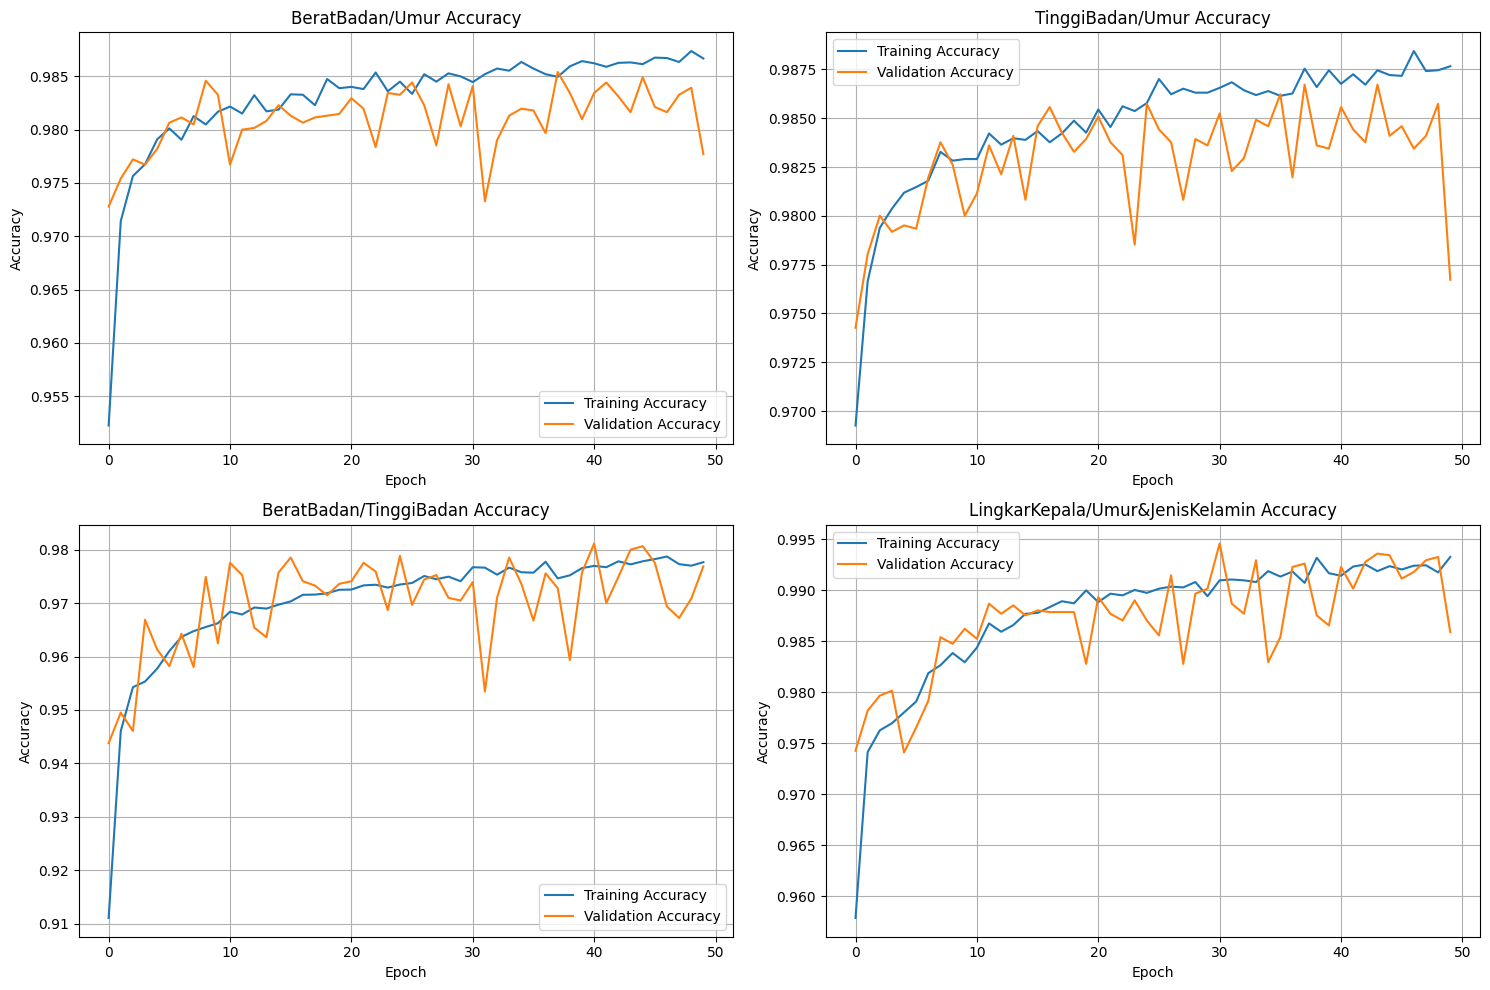

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot akurasi pelatihan dan validasi untuk BeratBadan/Umur
axes[0, 0].plot(history.history['output_1_accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_output_1_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('BeratBadan/Umur Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot akurasi pelatihan dan validasi untuk TinggiBadan/Umur
axes[0, 1].plot(history.history['output_2_accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_output_2_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('TinggiBadan/Umur Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot akurasi pelatihan dan validasi untuk BeratBadan/TinggiBadan
axes[1, 0].plot(history.history['output_3_accuracy'], label='Training Accuracy')
axes[1, 0].plot(history.history['val_output_3_accuracy'], label='Validation Accuracy')
axes[1, 0].set_title('BeratBadan/TinggiBadan Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot akurasi pelatihan dan validasi untuk LingkarKepala/Umur&JenisKelamin
axes[1, 1].plot(history.history['output_4_accuracy'], label='Training Accuracy')
axes[1, 1].plot(history.history['val_output_4_accuracy'], label='Validation Accuracy')
axes[1, 1].set_title('LingkarKepala/Umur&JenisKelamin Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Atur layout
plt.tight_layout()
plt.show()

In [58]:
model.save("model/MLP.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing Model

In [59]:
data_test = pd.read_csv('../dataset/test_data.csv')
data_test.head(10)

,Jenis_Kelamin(L/P),Usia(Bulan),Berat(Kg),Tinggi(Cm),Lingkar_Kepala(Cm),BeratBadan/Umur,TinggiBadan/Umur,BeratBadan/TinggiBadan,LingkarKepala/Umur&JenisKelamin
0,L,17,13.1,89.0,47.4,Lebih,Normal,Normal,Normal
1,P,55,15.8,98.0,50.3,Normal,Normal,Normal,Normal
2,L,56,19.0,107.0,49.4,Normal,Normal,Normal,Normal
3,P,15,8.0,73.0,40.6,Normal,Normal,Normal,Mikrosefali
4,L,60,17.8,102.6,58.6,Normal,Normal,Gizi Lebih,Makrosefali
5,P,49,15.0,105.0,43.3,Normal,Normal,Normal,Mikrosefali
6,P,26,12.4,81.0,47.4,Normal,Normal,Gizi Lebih,Normal
7,P,50,16.5,103.0,57.8,Normal,Normal,Normal,Makrosefali
8,P,3,5.7,60.0,38.8,Normal,Normal,Normal,Normal
9,P,40,13.6,94.0,42.7,Normal,Normal,Normal,Mikrosefali


In [60]:
numerik_fitur = [ 'Jenis_Kelamin(L/P)','Usia(Bulan)', 'Berat(Kg)', 'Tinggi(Cm)', 'Lingkar_Kepala(Cm)']

# Pastikan jenis kelamin sudah diubah menjadi angka 0 dan 1
data_test['Jenis_Kelamin(L/P)'] = data_test['Jenis_Kelamin(L/P)'].map({'L': 1, 'P': 0})

# Standarisasi data baru menggunakan scaler yang sama
data_test[numerik_fitur] = scaler.transform(data_test[numerik_fitur])

# Prediksi dengan model
predictions = model.predict(data_test[numerik_fitur])

239/239 [==============================] - 0s 2ms/step


In [61]:
predicted_categories = []
for i, pred in enumerate(predictions):
    predicted_category = np.argmax(pred, axis=-1)
    decoded_category = label_encoders[list(label_encoders.keys())[i]].inverse_transform(predicted_category)
    predicted_categories.append(decoded_category)

In [62]:
hasil_prediksi = pd.DataFrame({
    'BeratBadan/Umur': predicted_categories[0],
    'TinggiBadan/Umur': predicted_categories[1],
    'BeratBadan/TinggiBadan': predicted_categories[2],
    'LingkarKepala/Umur&JenisKelamin': predicted_categories[3]
})

In [63]:
result = pd.concat([data_test, hasil_prediksi], axis=1)
result.head(20)

,Jenis_Kelamin(L/P),Usia(Bulan),Berat(Kg),Tinggi(Cm),Lingkar_Kepala(Cm),BeratBadan/Umur,TinggiBadan/Umur,BeratBadan/TinggiBadan,LingkarKepala/Umur&JenisKelamin,BeratBadan/Umur,TinggiBadan/Umur,BeratBadan/TinggiBadan,LingkarKepala/Umur&JenisKelamin
0,0.932890,-0.801175,0.181391,0.085029,0.046060,Lebih,Normal,Normal,Normal,Lebih,Normal,Normal,Normal
1,-1.071938,1.448301,0.930159,0.692134,0.717776,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
2,0.932890,1.507498,1.817587,1.299239,0.509312,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
3,-1.071938,-0.919568,-1.232949,-0.994269,-1.528998,Normal,Normal,Normal,Mikrosefali,Normal,Normal,Normal,Mikrosefali
4,0.932890,1.744285,1.484801,1.002432,2.640273,Normal,Normal,Gizi Lebih,Makrosefali,Normal,Normal,Gizi Lebih,Makrosefali
5,-1.071938,1.093121,0.708301,1.164327,-0.903608,Normal,Normal,Normal,Mikrosefali,Normal,Normal,Normal,Mikrosefali
6,-1.071938,-0.268404,-0.012734,-0.454620,0.046060,Normal,Normal,Gizi Lebih,Normal,Normal,Pendek,Gizi Lebih,Normal
7,-1.071938,1.152318,1.124284,1.029414,2.454972,Normal,Normal,Normal,Makrosefali,Normal,Normal,Normal,Makrosefali
8,-1.071938,-1.629929,-1.870788,-1.871199,-1.945926,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
9,-1.071938,0.560350,0.320051,0.422309,-1.042583,Normal,Normal,Normal,Mikrosefali,Normal,Normal,Normal,Mikrosefali


In [68]:
result.to_csv('../dataset/predict.csv', index=False)